<a href="https://colab.research.google.com/github/commitit/NLP/blob/main/NLP_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p>
CAS on Advanced Machine Learning <br>
Data Science Lab, University of Bern, 2024 <br>
Prepared by Dr. Mykhailo Vladymyrov.

</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Install libs

In [ ]:
!pip install nltk spacy scikit-learn gensim matplotlib seaborn pandas tqdm flair

# Thu morning 1 (NN on tf-idf)

In this session we will continue with building simple neural networks.
We will use the more sophisticated features, and rely on previously established intuition about building the NNs.

## 1. Imports

In [ ]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## 2. Fetch dataset

In [ ]:
fetch_20newsgroups().target_names

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

We strip the headers and footers, as those can make the task easier.

In [ ]:
# Load the 20 Newsgroups dataset
categories = ['rec.sport.hockey', 'sci.electronics', 'comp.graphics']
SEED = 64
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=SEED, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=SEED,remove=('headers', 'footers', 'quotes'))

In [ ]:
# inspect the data structure
train_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
# inspect the data input elements, target, target_names, number of elements... (5 min)
for i in train_data.keys():
  print(i, type(train_data[i]), len(train_data[i]))

data <class 'list'> 1775
filenames <class 'numpy.ndarray'> 1775
target_names <class 'list'> 3
target <class 'numpy.ndarray'> 1775
DESCR <class 'str'> 10772


In [ ]:
a = []
for i in range (0,3):
  a = train_data['target_names']

print(a)


['comp.graphics', 'rec.sport.hockey', 'sci.electronics']


In [ ]:
# after add the `remove=('headers', 'footers', 'quotes')` argument to the `fetch_20newsgroups` call and repeat
# what changed?

## 2.1. Fetch dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path_to_csv = '/content/gdrive/MyDrive/Data/review.csv'

df = pd.read_csv(path_to_csv)

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(path_to_csv)

In [ ]:
df['sentiment'].replace({'positive':1,'negative':0},inplace=True)

In [ ]:
df.head(1)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1


In [ ]:
for i in range(len(df)):
   df['review'][i] = df['review'][i].strip(' \n\t\r')
   df['review'][i] = df['review'][i].replace('','')

<ipython-input-8-2f0377e853ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'][i] = df['review'][i].strip(' \n\t\r')
<ipython-input-8-2f0377e853ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'][i] = df['review'][i].replace('','')


In [ ]:
import re

# Define function to remove HTML tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')  # takes a text input and uses a regular expression pattern to remove HTML tags from it.
    return pattern.sub(r'', text)  # Remove HTML tags by an empty string

# Apply the remove_html_tags function to the 'review' column
df['review'] = df['review'].apply(remove_html_tags)

#Converting data into lowercase since python is case sensitive
df['review']=df['review'].str.lower()


#removing URLs from text using regular expression pattern to match URLs starting with "http://" or "https://" as well as URLs starting with "www."
def remove_url(text):
    pattern = re.compile(r'https?://\S+ | www\. \S+')
    return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_url)

In [ ]:
#split the dataset
#train dataset
train_data=df['review'][:10000]
train_label= df['sentiment'][:10000]

#test dataset
test_data=df['review'][45000:]
test_label= df['sentiment'][45000:]

In [ ]:
test_data.head(1)

45000    what i enjoyed most in this film was the scene...
Name: review, dtype: object

## 3. Preprocess and inspect dataset

In [ ]:
# Iterate over the train_data and test_data
for d in [train_data, test_data]:

  # Remove leading and trailing whitespace, tab,
  # and new line characters from each data point
  d['review'] = [s.strip(' \n\t\r') for s in d['review']]
  d['review'] = d['review'].replace('<br />','')
  # Get the indices of data points with non-empty content
  ok_idx = [i for i, s in enumerate(d['review']) if len(s) > 0]

  # Filter the data and target lists to keep only non-empty data points
  d['review'] = [d['review'][i] for i in ok_idx]
  d['sentiment'] = [d['sentiment'][i] for i in ok_idx]


In [ ]:
# inspect the data labels elements
#train_data.target

In [ ]:
len(train_data), len(test_data)

(10000, 5000)

In [ ]:
sample = train_data[1]
sample_label = train_label[1]


In [ ]:
print(sample)
print(f'label={sample_label}')

a wonderful little production. the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master's of comedy and his life. the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell's murals decorating every surface) are terribly well done.
label=1


https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
# Convert the text data to TF-IDF vectors, max 10 words
vectorizer = TfidfVectorizer(max_features=10)

# `object.fit` followed by processing by `object.transform` or the
# joined `object.fit_transform` is the
train_vectors = vectorizer.fit_transform(train_data)

test_vectors = vectorizer.fit_transform(test_data)


In [ ]:
# the vectors are stored in sparse format:
train_vectors

<10000x10 sparse matrix of type '<class 'numpy.float64'>'
	with 88683 stored elements in Compressed Sparse Row format>

In [ ]:
# to get the dense representation we need to convert them to an array:
train_vectors.toarray()

array([[0.25314576, 0.13771703, 0.40679646, ..., 0.13355695, 0.25911982,
        0.17701964],
       [0.37818308, 0.        , 0.17363632, ..., 0.        , 0.11060227,
        0.        ],
       [0.27447127, 0.29863719, 0.29404388, ..., 0.36202016, 0.2809486 ,
        0.38386427],
       ...,
       [0.187757  , 0.35750423, 0.35200549, ..., 0.14858783, 0.14414095,
        0.13129462],
       [0.15138108, 0.08235474, 0.24326415, ..., 0.23960104, 0.38738391,
        0.42343074],
       [0.32777718, 0.11887881, 0.11705035, ..., 0.        , 0.1118375 ,
        0.        ]])

In [ ]:
train_vectors.toarray().shape

(10000, 10)

In [ ]:
train_label.head(2)

0    1
1    1
Name: sentiment, dtype: int64

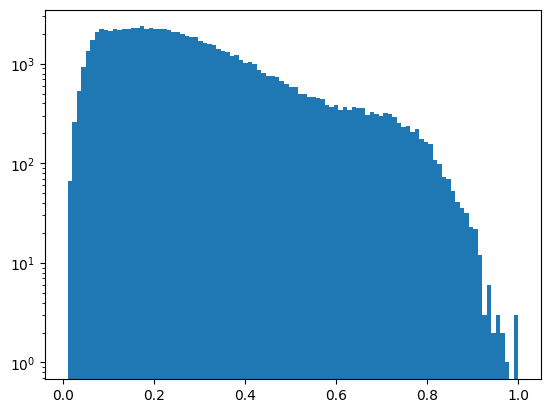

In [ ]:
af = train_vectors.toarray().flatten()
# plot only present words (tfidf>0)
aff = af[af>0]
plt.hist(aff, 100, log=True);

## 5. Exercise 1h + 30min discussion

Work in 3 groups:
 - present final group results in the end (10 min per group):
 - half time through - share code of your intermediate results (on Zoom) so that other groups use it for final results:

1. Optimize the model architecture to improve performance.
2. Study dependence of performance & training time on number of tf-idf features
3. Study relevant performance metrics. Make evaluation code for both training and the test sets.

# Thu morning 2: RNN on embeddings

## 1. Imports/utils

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as gd
from sklearn.datasets import fetch_20newsgroups

import re

In [ ]:
import nltk
import tqdm
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def load_pckl(file_name, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data


def save_pckl(d, file_name, pr=None, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'wb') as f:
        pickle.dump(d, f, protocol=pr if pr is not None else pickle.DEFAULT_PROTOCOL)

In [ ]:
def remove_punctuation(input_string):
    # Use regular expression to remove all punctuation characters
    return re.sub(r'[^\w\s]', '', input_string)  # everything which is not a word (\w) or space (\s) -> empty string ('')

## 2. Load and preprocess the dataset

In [ ]:
train_data

0       one of the other reviewers has mentioned that ...
1       a wonderful little production. the filming tec...
2       i thought this was a wonderful way to spend ti...
3       basically there's a family where a little boy ...
4       petter mattei's "love in the time of money" is...
                              ...                        
9995    fun, entertaining movie about wwii german spy ...
9996    give me a break. how can anyone say that this ...
9997    this movie is a bad movie. but after watching ...
9998    this is a movie that was probably made to ente...
9999    smashing film about film-making. shows the int...
Name: review, Length: 10000, dtype: object

## 3. Explore Word2Vec (Homework)

### 3. 300k words

Here a pretrained model on many news articles is downloaded (Downloading it can take a while!). Feature vectors are of length 300, total 300k words.

In [ ]:
model_gn300.vectors.shape

NameError: name 'model_gn300' is not defined

In [ ]:
word = "car"
similar_words = model_gn300.most_similar(word)
print(f"Similar words to '{word}':")
for word, similarity in similar_words:
    print(word, similarity)

NameError: name 'model_gn300' is not defined

## 4. Preparing embedding dataset (not run in the class - time-consuming)

### 0. Embedding utilities

First we create word embeddigns with Word2Vec

In [ ]:
# Download the word2vec-google-news-300 model
model_gn300 = gd.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_vec(model, word):
  # convert word to vector
  # Check if the model has an index for the word, of so get vector,
  # otherwise return None
  return model.get_vector(word) if model.has_index_for(word) else None

In [ ]:
# Function to convert text to word vectors
# using a specified word embedding model
# (default - word2vec-google-news-300 model, Download takes a while!
# you can also try yours)
def convert_text_to_vecs(text, model=model_gn300):
  # Tokenize the input text into individual words
  words = nltk.tokenize.word_tokenize(text)

  # Get word vectors for each word in the text using the specified word embedding model
  wvs = [get_vec(model, word) for word in words]

  # Filter out None values (word vectors that couldn't be found in the model)
  wvs = [v for v in wvs if v is not None]

  # Convert the list of word vectors to a NumPy array
  wvs = np.array(wvs)

  # Return the array of word vectors for the input text
  return wvs

NameError: name 'model_gn300' is not defined

Few helper functions to convert input dataset, and to save whole dataset to file

In [ ]:
def convert_corpus_to_vecs(corpus, convert_corpus_to_vecs_fn):
  # for each text in the corpus - vectorize it
  # using list comprehension. Use tqdm to display progress
  return [convert_corpus_to_vecs_fn(text) for text in tqdm.auto.tqdm(corpus)]

In [ ]:
def prepare_embedding_dataset(tra_input, tra_labels,
                              val_input, val_labels,
                              filename,
                              convert_text_to_vecs_fn):
  # Prepare and save an embedding dataset for training and validation.
  print('embedding training data:')
  tra_data_vecs = convert_corpus_to_vecs(tra_input, convert_text_to_vecs_fn)

  print('embedding validation data:')
  val_data_vecs = convert_corpus_to_vecs(val_input, convert_text_to_vecs_fn)

  # remove empty elements
  ok_idx = [i for i, s in enumerate(tra_data_vecs) if len(s)>0]
  tra_data_vecs = [tra_data_vecs[i] for i in ok_idx]
  tra_labels = [tra_labels[i] for i in ok_idx]

  ok_idx = [i for i, s in enumerate(val_data_vecs) if len(s)>0]
  val_data_vecs = [val_data_vecs[i] for i in ok_idx]
  val_labels = [val_labels[i+45000] for i in ok_idx]

  print(f'preparing and saving dataset to: {filename}')

  # Create a dataset dictionary containing training and validation data and labels
  dataset = {
    'tra_data': tra_data_vecs,
    'tra_labels': tra_labels,
    'val_data': val_data_vecs,
    'val_labels': val_labels,
  }

  # Save the dataset as a pickle file
  save_pckl(dataset, filename, path='./')

GloVe and RoBERTa embeddings (with flair)

In [ ]:
!pip install --upgrade urllib3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flair 0.13.1 requires urllib3<2.0.0,>=1.0.0, but you have urllib3 2.2.1 which is incompatible.


In [ ]:

from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, TransformerWordEmbeddings
from flair.data import Sentence

In [ ]:
# Download models for word embeddings with GloVe and RoBERTa
glove_embedding = WordEmbeddings('glove')
roberta_embedding = TransformerWordEmbeddings('roberta-base')

# Create a DocumentPoolEmbeddings object (optional but helpful)
document_embeddings_glove = DocumentPoolEmbeddings([glove_embedding])
document_embeddings_roberta = DocumentPoolEmbeddings([roberta_embedding])


2024-03-18 07:36:37,953 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmp0fmmvzov


100%|██████████| 153M/153M [00:06<00:00, 23.3MB/s]

2024-03-18 07:36:45,273 copying /tmp/tmp0fmmvzov to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2024-03-18 07:36:47,600 removing temp file /tmp/tmp0fmmvzov
2024-03-18 07:36:48,079 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpyuvijsmw


100%|██████████| 20.5M/20.5M [00:01<00:00, 12.3MB/s]

2024-03-18 07:36:50,277 copying /tmp/tmpyuvijsmw to cache at /root/.flair/embeddings/glove.gensim
2024-03-18 07:36:50,308 removing temp file /tmp/tmpyuvijsmw



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def convert_text_to_embedding(text, doc_embedding_model):
  # Create a Flair Sentence object
  sentence = Sentence(text)

  # Embed the sentence
  try:
    doc_embedding_model.embed(sentence)
  except Exception as e:
    # if model can't convert a text - print it, before raising the exception
    print('failed text:', text)
    raise e

  embeddings = [token.embedding.cpu().numpy() for token in sentence]
  return np.array(embeddings)

In [ ]:
def convert_text_to_glove(text):
  return convert_text_to_embedding(text, document_embeddings_glove)

def convert_text_to_roberta(text):
  return convert_text_to_embedding(text, document_embeddings_roberta)


### 1. Create word2vec embeddings

In [ ]:
prepare_embedding_dataset(train_data.data, train_data.target,
                          test_data.data, test_data.target,
                          filename='dataset_20newsgroups_3_cat.pckl',
                          convert_text_to_vecs_fn=convert_text_to_vecs
                          )

AttributeError: 'Series' object has no attribute 'data'

In [ ]:
import os
import pickle
df.to_pickle('/content/gdrive/MyDrive/Data/review.pkl')

In [ ]:
!mv dataset_20newsgroups_3_cat.pckl "/content/drive/MyDrive/Colab Data/NLP_data"

### 2. Create GloVe embeddings

In [ ]:
prepare_embedding_dataset(train_data, train_label,
                          test_data, test_label,
                          filename='dataset_review_gl.pckl',
                          convert_text_to_vecs_fn=convert_text_to_glove
                          )

embedding training data:


  0%|          | 0/10000 [00:00<?, ?it/s]

embedding validation data:


  0%|          | 0/5000 [00:00<?, ?it/s]

preparing and saving dataset to: dataset_review_gl.pckl


In [ ]:
!mv dataset_review_gl.pckl "/content/gdrive/MyDrive/Data"

### 3. Create RoBERTa embeddings (run with a GPU)

In [ ]:
prepare_embedding_dataset(train_data.data, train_data.target,
                          test_data.data, test_data.target,
                          filename='dataset_review_rb.pckl',
                          convert_text_to_vecs_fn=convert_text_to_roberta
                          )

In [ ]:
!mv dataset_review_gl.pckl "/content/gdrive/MyDrive/Data"

### 4. Inspect prepared datasets:

In [ ]:
dataset_gb = load_pckl('dataset_review_gl.pckl', '/content/gdrive/MyDrive/Data')

In [ ]:
tra_data = dataset_gb['tra_data']
tra_labels = dataset_gb['tra_labels']
val_data = dataset_gb['val_data']
val_labels = dataset_gb['val_labels']

In [ ]:
len(tra_data), len(tra_labels), len(val_data), len(val_labels)

(10000, 10000, 5000, 5000)

In [ ]:
tra_data[200].shape

(106, 100)

## 5. LSTM Training:

In [ ]:
ds_name = 'dataset_review_gl.pckl'


# Load the embedded 20 Newsgroups dataset
dataset = load_pckl(ds_name,
                    '/content/gdrive/MyDrive/Data')
tra_data = dataset['tra_data']
tra_labels = dataset['tra_labels']
val_data = dataset['val_data']
val_labels = dataset['val_labels']

ok_idx = [i for i, s in enumerate(tra_data) if len(s)>0]
tra_data = [tra_data[i] for i in ok_idx]
tra_labels = [tra_labels[i] for i in ok_idx]

ok_idx = [i for i, s in enumerate(val_data) if len(s)>0]
val_data = [val_data[i] for i in ok_idx]
val_labels = [val_labels[i] for i in ok_idx]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 50

# make preprocessing function converting data to torch tensors
def preprocess(data, labels):
    # Make random crops of the sequences up to max_len length,
    # Pad short sequences to ensure consistent sequence length
    max_len = 256  # Maximum sequence length
    lens = [len(d) for d in data]  # Get the length of each data point

    # Calculate random offsets for padding
    ofs = [np.random.randint(0, max(1, len_i - max_len)) for len_i in lens]

    # Apply padding based on offsets
    data = [d[o:o + max_len] for d, o in zip(data, ofs)]
    max_len = max([len(d) for d in data])  # Update maximum sequence length after padding

    # Pad sequences with zeros to match the maximum sequence length
    # pad_width contains size of padding  left and righ in each dimension
    data_padded = [np.pad(d, pad_width=((0, max_len - len(d)),
                                        (0, 0))) for d in data]

    # Convert data and labels to NumPy arrays
    data_padded = np.array(data_padded)
    labels = np.array(labels)

    # Convert NumPy arrays to PyTorch tensors
    # and move them to the specified device (e.g., GPU)
    data_t = torch.tensor(data_padded, dtype=torch.float32).to(device)
    labels_t = torch.tensor(labels, dtype=torch.int64).to(device)

    return data_t, labels_t

# make data loader

train_loader = DataLoader(list(zip(tra_data, tra_labels)),
                          batch_size=batch_size, shuffle=True,
                          collate_fn=lambda x: preprocess(*zip(*x)))

test_loader = DataLoader(list(zip(val_data, val_labels)),
                         batch_size=batch_size, shuffle=True,
                         collate_fn=lambda x: preprocess(*zip(*x)))

In [ ]:
# complete the code below (20 min)

In [ ]:
class ClassificationRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(ClassificationRNN, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)

        if type(hidden_dim) == int:
          hidden_dim = [hidden_dim]

        self.rnn = []
        for i, hidd_d in enumerate(hidden_dim):
          prev_d = embedding_dim if i == 0 else hidden_dim[i-1]
          rnn = nn.LSTM(prev_d, hidd_d, batch_first=True)

          # most important line:
          self.add_module(f'lstm_{i}', rnn)
          self.rnn.append(rnn)

        self.fc = nn.Linear(hidd_d, output_dim)

    def forward(self, x):
        # apply embedding layer and relu to the input
        embedded = torch.relu(self.embedding(x))
        # apply each rnn layer. tip: what does each layer return?
        for rnn in self.rnn:
          embedded, (hidden_hn, hidden_cn) = rnn(embedded)

        output = embedded
        rnn_out = hidden_hn[0]  # hn
        return self.fc(rnn_out)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Initialize the model
input_dim = tra_data[0].shape[1]
embedding_dim = 256
hidden_dim = [128, 16]  # you can specify a list of number of units in sequential LSTM layers
output_dim = 2

model = ClassificationRNN(input_dim, embedding_dim, hidden_dim, output_dim).to(device)

# Define the sparse cross-entropy loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005)

# Train the model
n_epochs = 10

tra_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(n_epochs):
    train_loss = 0.
    valid_loss = 0.

    model.train()
    for batch in train_loader:
        data, labels = batch
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, labels)
        loss.backward()

        # perform a training update:
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)
    tra_loss_hist.append(train_loss)

    model.eval()
    with torch.no_grad():
        correct = []
        for batch in test_loader:
            data, labels = batch
            output = model(data)
            loss = criterion(output, labels)

            valid_loss += loss.item()

            pred_class = torch.argmax(output, dim=1)
            corr = pred_class == labels
            correct.append(corr.detach().cpu().numpy())

        valid_loss /= len(test_loader)
        correct = np.concatenate(correct)
        accuracy = np.mean(correct)
        print(f"{epoch}:\t Test loss: {valid_loss}; accuracy: {accuracy}")

        val_loss_hist.append(valid_loss)
        val_acc_hist.append(accuracy)

TypeError: preprocess() missing 1 required positional argument: 'labels'

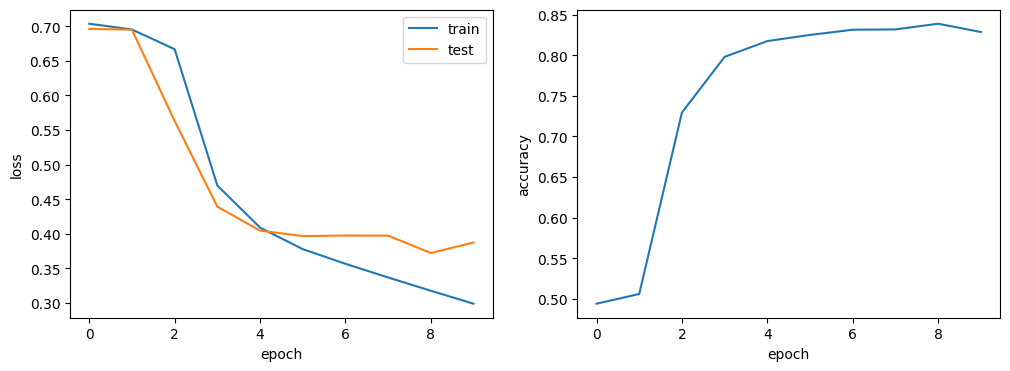

best validation accuracy: 0.8388 @ epoch 8


In [ ]:
# plot loss and accuracy on 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(tra_loss_hist, label='train')
ax1.plot(val_loss_hist, label='test')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(val_acc_hist)
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
plt.show()

print(f'best validation accuracy: {np.max(val_acc_hist)} @ epoch {np.argmax(val_acc_hist)}')

In [ ]:
datatest = ['hate the movie']
datatest = vectorizer.fit_transform(datatest)

data_test_t = torch.tensor(datatest.toarray(), dtype=torch.float).to(device)

test_loader = DataLoader(list(zip(val_data, val_labels)),
                         batch_size=batch_size, shuffle=True,
                         collate_fn=lambda x: preprocess(*zip(*x)))


model.eval()
with torch.no_grad():
  for batch in test_loader:
            data, labels = batch
            output = model(data)
  output = model(data_test_t)




RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 100x256)

In [ ]:
datatest = ['hate the movie']
datatest = vectorizer.fit_transform(datatest)

data_test_t = torch.tensor(datatest.toarray(), dtype=torch.float).to(device)

In [ ]:
data_test_t.shape


torch.Size([1, 3])

In [ ]:

model.eval()
with torch.no_grad():
  output = model(data_test_t)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 100x256)

## 6. Exercise 1.

Work in 3 groups, use the 3 datasets.
Optimize the model architecture: # layers, units per layer (hidden_dim) and the embedding_dim to improve validation accuracy.

## 7. Tip

Same Flair interface as for Glove and Roberta, can be used to concatenate embeddings from several models, including your own ones. E.g., given your model file 'my_model.pt', you can create document embedder:

```
my_model = torch.load('my_model.pt')
document_embeddings_my_model = DocumentPoolEmbeddings([my_model])
```

alternatively - you can combine the Glove embeddings and your emebedding, or the roberta ones:
```
document_embeddings_stacked = DocumentPoolEmbeddings([my_model, glove_embedding])
```

# Thu evening-Friday morning (Transfer learning for PoS tagging/NER)

### 0. Libs and utils

In [ ]:
!pip install transformers[torch] datasets evaluate seqeval

In [ ]:
from datasets import load_dataset
import datasets

from transformers import AutoTokenizer

from transformers import AutoModelForTokenClassification, AutoModel
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import evaluate

import torch.cuda
import torch

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### 1. load dataset

Dataset info: https://huggingface.co/datasets/conll2003

In [ ]:
dataset = load_dataset("conll2003", num_proc=4)

In [ ]:
# inspect the dataset object (10 min):
# 1. length of tra & test parts
# 2. column names
# 3. features
# ????

https://cs.nyu.edu/~grishman/jet/guide/PennPOS.html

In [ ]:
pos_tags_info = dataset['train'].features['pos_tags'].feature
class_names = pos_tags_info.names

class_idx_to_class_name = dict(enumerate(class_names))
class_name_to_class_idx = {v:k for k, v in class_idx_to_class_name.items()}
n_classes = len(class_names)

class_types = list(set(class_names))  # get unique

class_idx_to_class_name

### 2. Load tokenizer

In the transformer library for most models you have the associated tokenizer.

The methods AutoTokenizer and AutoModel instantiate a model of proper type.

In [ ]:
mod_name = 'bert-base-uncased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(mod_name)

In [ ]:
tokens = tokenizer.tokenize("Decoding is going the other way around: from vocabulary indices, we want to get a string. This can be done with the decode() method as follows")
print(tokens)

In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

In [ ]:
decoded = tokenizer.decode(token_ids)
print(decoded)

In [ ]:
# play with tokenizer (10 min). How is the splitting performed?

In [ ]:
# discuss

### 3. Load model

In [ ]:
model = AutoModel.from_pretrained(mod_name)

In [ ]:
example = dataset["test"][560]
example_txt = example['tokens']
print(example_txt)

In [ ]:
example_tokens_ids = tokenizer(example_txt, is_split_into_words=True, return_tensors='pt')
example_tokens_ids

In [ ]:
np_ids = example_tokens_ids['input_ids'].numpy()[0]
tokens_r = tokenizer.convert_ids_to_tokens(np_ids)
text_r = tokenizer.convert_tokens_to_string(tokens_r)
text_r
#tokens_r

In [ ]:
res = model(**example_tokens_ids)

In [ ]:
for k, v in res.items():
  print(k, v.shape)

So.. What kind of model is this 'bert-base-uncased'?

Lets use it for transfer learning - we use it's features to do token classification. For this we create a model of type `AutoModelForTokenClassification`:

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(mod_name, num_labels=n_classes).to(device)

In [ ]:
res = model(**example_tokens_ids.to(device))

In [ ]:
for k, v in res.items():
  print(k, v.shape)

### 4. Prepare dataset

we can use the tokenizer to covert text into token-ids. but there will be more of them than words. Our lables - are word based. We need thus to generate proper label - per token:

In [ ]:
# study the function (10 min)
def tokenize_ner(examples, print_info=False):
  # Extract word tokens and NER labels from examples
  batch_words = examples['tokens']  # these are word tokens
  batch_ner_tags = examples['pos_tags']  # examples['ner_tags']  # these are NER-labels per word

  batch_tokens = tokenizer(batch_words, is_split_into_words=True, truncation=True)
  batch_labels = []

  LBL_IGN = -100  # label for tokens to be ignored during training

  # Iterate through each example in the batch
  for sample_idx, sample_ner_tags in enumerate(batch_ner_tags):
    sample_labels = []  # To store NER labels for tokens in the current example

    word_idxs = batch_tokens.word_ids(batch_index=sample_idx)
    if print_info:
      sample_token_ids = batch_tokens['input_ids'][sample_idx]
      print(word_idxs, sample_ner_tags, tokenizer.convert_ids_to_tokens(sample_token_ids))

    for word_idx in word_idxs:
      if word_idx is None:  # Ignore tokens that are not related to real words
        sample_labels.append(LBL_IGN)
      else:
        token_label = sample_ner_tags[word_idx]
        sample_labels.append(token_label)  # Store the NER label for the token

    # Add the NER labels for the current example to the batch_labels list
    batch_labels.append(sample_labels)

  # Add the batch_labels to the tokenized batch
  batch_tokens['labels'] = batch_labels

  return batch_tokens

Lets inspect what and how does it do:

In [ ]:
res = tokenize_ner(dataset['train'][560:564], print_info=True)
print(res)

In [ ]:
for token, token_id, label in zip(tokenizer.convert_ids_to_tokens(res['input_ids'][0]), res['input_ids'][0], res['labels'][0]):
  print(f'{token:<15} {token_id:<10} {label}')

In [ ]:
tokenized_datasets = dataset.map(tokenize_ner, batched=True, num_proc=4)

In [ ]:
tokenized_datasets['train'][560]

In [ ]:
tokenized_datasets['train'][0].keys()

In [ ]:
res = model(input_ids=torch.tensor(tokenized_datasets['train'][560:561]['input_ids']).to(device))

In [ ]:
for k, v in res.items():
  print(k, v.shape)

Lastly we need a collator.

It ensures that tokenized inputs, labels, and other relevant data are properly formatted and batched together during training. This is particularly useful for tasks like Named Entity Recognition (NER) and part-of-speech tagging where token-level labels need to be aligned with input tokens.

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### 5. Performnce evaluation

In [ ]:
metric = evaluate.load("poseval")  # seqeval for NER

In [ ]:
# Define a function to compute evaluation metrics for a given batch of predictions and labels.
# The function takes eval_pred as input, which contains batch_logits and batch_labels.
def compute_metrics(eval_pred, print_info=False):
    # Extract batch_logits and batch_labels from eval_pred.
    batch_logits, batch_labels = eval_pred

    # Compute batch_predictions by selecting the class with the highest probability.
    batch_predictions = np.argmax(batch_logits, axis=-1)

    # Initialize lists to store filtered predictions and labels for each sample in the batch.
    filtered_hr_batch_predictions = []
    filtered_hr_batch_labels = []

    # Iterate over samples in the batch to filter out padding tokens (-100).
    for sample_prediction, sample_label in zip(batch_predictions, batch_labels):
        filtered_hr_sample_predictions = []
        filtered_hr_sample_labels = []

        # Iterate over predictions and labels in each sample.
        for prediction, label in zip(sample_prediction, sample_label):
            # Check if the label is not a padding token (-100).
            if label != -100:
                # Convert prediction and label indices to class names using class_idx_to_class_name mapping.
                filtered_hr_sample_predictions.append(class_idx_to_class_name[prediction])
                filtered_hr_sample_labels.append(class_idx_to_class_name[label])

        # Append filtered predictions and labels for the sample to the batch lists.
        filtered_hr_batch_predictions.append(filtered_hr_sample_predictions)
        filtered_hr_batch_labels.append(filtered_hr_sample_labels)

    # Compute evaluation metrics using the filtered predictions and labels.
    metric_res = metric.compute(predictions=filtered_hr_batch_predictions,
                                references=filtered_hr_batch_labels)

    # Optionally print information about filtered predictions, labels, and metric results.
    if print_info:
        print(filtered_hr_batch_predictions)
        print(filtered_hr_batch_labels)
        print(metric_res)

    # Create a dictionary to store computed metrics.
    all_metrics = {k: v for k, v in metric_res.items() if type(v) is not dict}
    all_metrics = {**all_metrics, **metric_res['weighted avg']}

    # Compute and add F1 scores for specific class types to the metrics dictionary.
    for ct in class_types:
        v = metric_res.get(ct, None)
        all_metrics[ct + '_f1'] = v['f1-score'] if v is not None else 0.

    # Return the computed evaluation metrics.
    return all_metrics

In [ ]:
ds_test = tokenized_datasets['test']

res = model(input_ids=torch.tensor(ds_test['input_ids'][:1]).to(device),
            attention_mask=torch.tensor(ds_test['attention_mask'][:1]).to(device)
            )

In [ ]:
# don't forget to copy data to cpu-accessibel memory and convert to NumPy
pred = res.logits.detach().cpu().numpy()
lbl = tokenized_datasets['test']['labels'][:1]

In [ ]:
metrics_res = compute_metrics((pred, lbl), print_info=True)

In [ ]:
metrics_res

Since the last model layer doing the 47-way classification is not yet trained - the model spits out rubbish, and the scores are 0

### 6. Training

In [ ]:
# rm -rf ner logs_ner

In [ ]:
rm -rf pos logs_pos

In [ ]:
training_args = TrainingArguments(output_dir="pos",
                                  num_train_epochs=10,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",

                                  per_device_train_batch_size=16,  # batch size per device during training
                                  per_device_eval_batch_size=16,   # batch size for evaluation
                                  warmup_steps=250,                # number of warmup steps for learning rate scheduler
                                  weight_decay=0.01,               # strength of weight decay
                                  logging_dir='./logs_pos',        # directory for storing logs
                                  logging_steps=10,
                                  # optim="adafactor"
                                  )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [ ]:
!ls

In [ ]:
trainer.train()

In [ ]:
def plot_hist(log_hist):
  """
  Helper function to aggregate and visualize training history
  from trainers's logs
  """
  last_loss = 0
  s = 4
  sfx = 'eval_'
  e_loss_name = sfx+'loss'
  sfx_skip = ['_per_second', 'runtime', 'epoch', 'step', 'confusion_matrix']

  steps = []
  loss = []

  e_steps = []
  e_loss = []
  e_mtr = {}

  e_cms = []

  for el in log_hist:
    if e_loss_name in el:
      for k, v in el.items():
        if any([s in k for s in sfx_skip]):
          continue


        if k == e_loss_name:
          e_loss.append(v)
        else:
          if k not in e_mtr:
            e_mtr[k] = []
          e_mtr[k].append(v)

      e_steps.append(el['step'])
      if 'confusion_matrix' in el:
        e_cms.append(el['confusion_matrix'])

    else:
      if 'loss' in el:
        steps.append(el['step'])
        loss.append(el['loss'])

  n_fig = len(e_mtr)+1

  fix, ax = plt.subplots(1, n_fig, figsize=(s*n_fig, s*1))
  ax[0].plot(steps, loss, alpha=0.5, label='tra')
  ax[0].plot(e_steps, e_loss, alpha=0.5, label='val')
  ax[0].set_xlabel('steps')
  ax[0].set_title('loss')
  ax[0].legend()

  for idx, (lbl, vals) in enumerate(e_mtr.items()):
    i = idx+1

    #print(lbl, vals, e_steps)
    ax[i].plot(e_steps, vals, alpha=0.5, label='val')
    ax[i].set_xlabel('steps')
    ax[i].set_title(lbl)

    #ax[i].legend()

  plt.show()
  plt.close()

  for i, cm in enumerate(e_cms):
    plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    plt.title(e_steps[i])
    plt.show()

In [ ]:
# summarize the steps in a flowchart on a whiteboard (15 min)

In [ ]:
plot_hist(trainer.state.log_history)

### 7. Exercise

Try modifying the code to do NER tag identification